In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path='/content/drive/MyDrive/NK_Hack/train_data.parquet'

In [4]:
df=pd.read_parquet(file_path,engine='auto')

In [5]:
df.head()

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063


In [6]:
file_path_test='/content/drive/MyDrive/NK_Hack/test_data.parquet'
test_df=pd.read_parquet(file_path_test,engine='auto')
train_cols = df.columns
test_cols = test_df.columns
iv_cols = [col for col in df.columns if "_iv_" in col]
# cols involving iv data
test_iv_cols = [col for col in test_df.columns if "_iv_" in col]
train_call_iv_cols = [col for col in train_cols if "call_iv_" in col]
train_put_iv_cols = [col for col in train_cols if "put_iv_" in col]
test_call_iv_cols = [col for col in test_cols if "call_iv_" in col]
test_put_iv_cols = [col for col in test_cols if "put_iv_" in col]
# cols involving iv data
# Columns in train but not in test, in original train order
train_spec_cols = [col for col in train_cols if col not in test_cols]
train_spec_call_iv_cols=[col for col in train_spec_cols if "call_iv_" in col]
train_spec_put_iv_cols=[col for col in train_spec_cols if "put_iv_" in col]
# Columns in test but not in train, in original test order
test_spec_cols = [col for col in test_cols if col not in train_cols]
test_spec_call_iv_cols=[col for col in test_spec_cols if "call_iv_" in col]
test_spec_put_iv_cols=[col for col in test_spec_cols if "put_iv_" in col]
common_call_iv_cols = [col for col in train_call_iv_cols if col in test_call_iv_cols]
common_put_iv_cols = [col for col in train_put_iv_cols if col in test_put_iv_cols]

In [7]:
common_cols=common_call_iv_cols+common_put_iv_cols

In [8]:
file_path='/content/drive/MyDrive/NK_Hack/df_ready_export.csv'
df_ready_2=pd.read_csv(file_path)
df_ready_2.drop(train_spec_cols,inplace=True,errors='ignore')
df_ready_2.shape

(138577, 147)

In [9]:
file_path_test='/content/drive/MyDrive/NK_Hack/df_spline_fill.csv'
df_fire_imputed_spline=pd.read_csv(file_path_test)

In [10]:
df.describe()

,timestamp,underlying,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,call_iv_24200,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
count,1.783400e+05,178340.000000,178340.000000,1.783400e+05,178340.000000,1.783400e+05,1.783400e+05,178340.000000,178340.000000,178340.000000,...,178340.000000,178340.000000,1.783400e+05,178340.000000,178340.000000,178340.000000,1.783400e+05,1.783400e+05,1.783400e+05,1.783400e+05
mean,1.746052e+18,24323.883938,0.423909,-3.220020e+07,0.349236,3.499773e+05,1.429192e+03,1.580317,0.195213,0.160997,...,0.000277,0.000014,-1.421471e+04,0.000588,-0.093444,0.000832,-1.877999e+04,-1.383081e+05,-4.700416e+03,-3.956062e+02
std,3.824884e+14,129.485600,2.178706,6.800128e+09,1.984786,7.389699e+07,5.550653e+05,402.799771,0.056097,0.032196,...,0.016701,0.008653,2.262233e+06,0.039787,2.346862,0.085648,4.314987e+06,1.873729e+07,7.563046e+05,1.225248e+06
min,1.745296e+18,23865.200000,0.186658,-1.435870e+12,0.036630,-1.244180e+05,-9.622650e+04,-0.045733,0.123994,0.074081,...,-0.275930,-0.144559,-1.019237e+08,-0.625017,-16.815711,-2.586113,-2.726196e+08,-4.113054e+08,-8.211573e+07,-3.067265e+08
25%,1.745818e+18,24280.600000,0.256790,2.417285e-01,0.226604,2.107440e-01,1.925507e-01,0.173014,0.161050,0.143029,...,-0.007785,-0.004317,-6.453953e+05,-0.018780,-1.098059,-0.022254,-7.875973e+05,-5.170499e+06,-1.279849e+05,-0.000000e+00
50%,1.745995e+18,24347.000000,0.297625,2.770240e-01,0.256366,2.354450e-01,2.165680e-01,0.196701,0.174057,0.157880,...,0.000258,0.000012,0.000000e+00,0.000566,-0.006216,0.000048,4.336592e+03,-2.000000e-06,0.000000e+00,0.000000e+00
75%,1.746432e+18,24385.200000,0.404716,3.753433e-01,0.346050,3.155980e-01,2.813773e-01,0.246242,0.210348,0.168074,...,0.008461,0.004381,6.062090e+05,0.020147,0.965078,0.023691,8.029313e+05,5.008932e+06,1.150824e+05,0.000000e+00
max,1.746610e+18,24668.500000,912.411000,7.904570e+08,833.879000,1.560360e+10,2.334040e+08,120282.000000,0.633309,0.445672,...,0.402689,0.191822,4.357080e+07,0.841955,22.124694,2.564958,2.498199e+08,6.597803e+08,2.846932e+07,1.981789e+08


In [11]:
df.shape

(178340, 97)

In [12]:
file_path_test='/content/drive/MyDrive/NK_Hack/test_data.parquet'
test_df=pd.read_parquet(file_path_test,engine='auto')
train_cols = df.columns
test_cols = test_df.columns
# Columns in train but not in test, in original train order
train_spec_cols = [col for col in train_cols if col not in test_cols]

# Columns in test but not in train, in original test order
test_spec_cols = [col for col in test_cols if col not in train_cols]

print("Ordered columns in train_data.parquet that are absent in test parquet:", train_spec_cols)
print("Ordered columns in test_data.parquet that are absent in train parquet:", test_spec_cols)


Ordered columns in train_data.parquet that are absent in test parquet: ['expiry', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800', 'put_iv_22900']
Ordered columns in test_data.parquet that are absent in train parquet: ['call_iv_26100', 'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300', 'put_iv_25400', 'put_iv_25500']


In [13]:
file_path='/content/drive/MyDrive/NK_Hack/df_ready_export.csv'
df_ready_2=pd.read_csv(file_path)
df_ready_2.drop(train_spec_cols,inplace=True,errors='ignore')
df_ready_2.shape

(138577, 147)

In [14]:
file_path_test='/content/drive/MyDrive/NK_Hack/df_spline_fill.csv'
df_fire_imputed_spline=pd.read_csv(file_path_test)

In [15]:
df.drop(train_spec_cols,axis=1,inplace=True)

In [16]:
df.shape

(178340, 86)

In [17]:
iv_cols = [col for col in df.columns if "_iv_" in col]
# cols involving iv data

In [18]:
test_iv_cols = [col for col in test_df.columns if "_iv_" in col]
# cols involving iv data

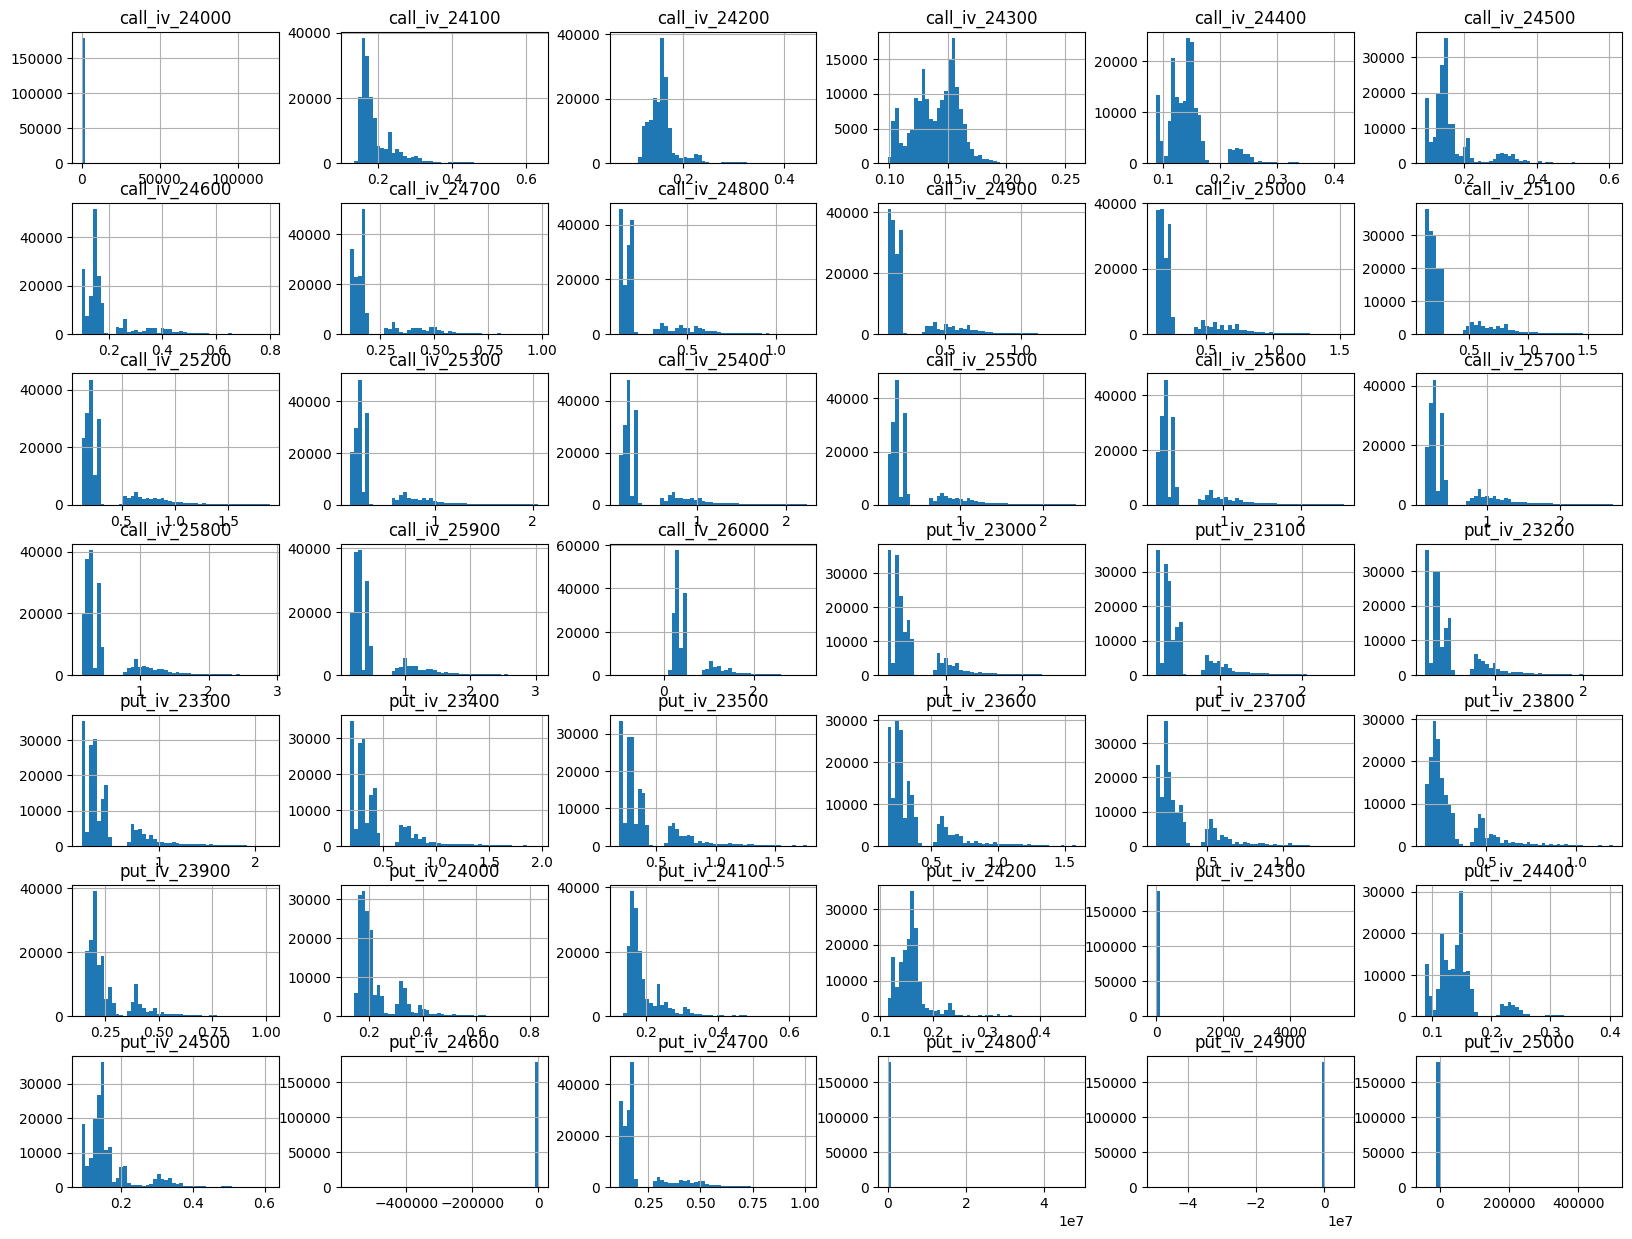

In [19]:
#plot iv_cols from df_1 as histogram

df[iv_cols].hist(bins=50, figsize=(20,15))
plt.show()

In [20]:
# prompt: cells with _iv_ columns should lie between 0 and 2

# Identify columns that contain '_iv_'
iv_cols = [col for col in df.columns if "_iv_" in col]

# Filter the DataFrame to keep only rows where all _iv_ columns are between 0 and 2
df_filtered = df[(df[iv_cols] >= 0.05).all(axis=1) & (df[iv_cols] <= 0.7).all(axis=1)]

# You can now work with df_filtered which contains the data that satisfies the condition
# print the shape of the filtered dataframe to see how many rows remain
print(f"Original shape: {df.shape}")
print(f"Filtered shape: {df_filtered.shape}")

# Optionally, you can replace the original dataframe with the filtered one
# df = df_filtered

Original shape: (178340, 86)
Filtered shape: (138577, 86)


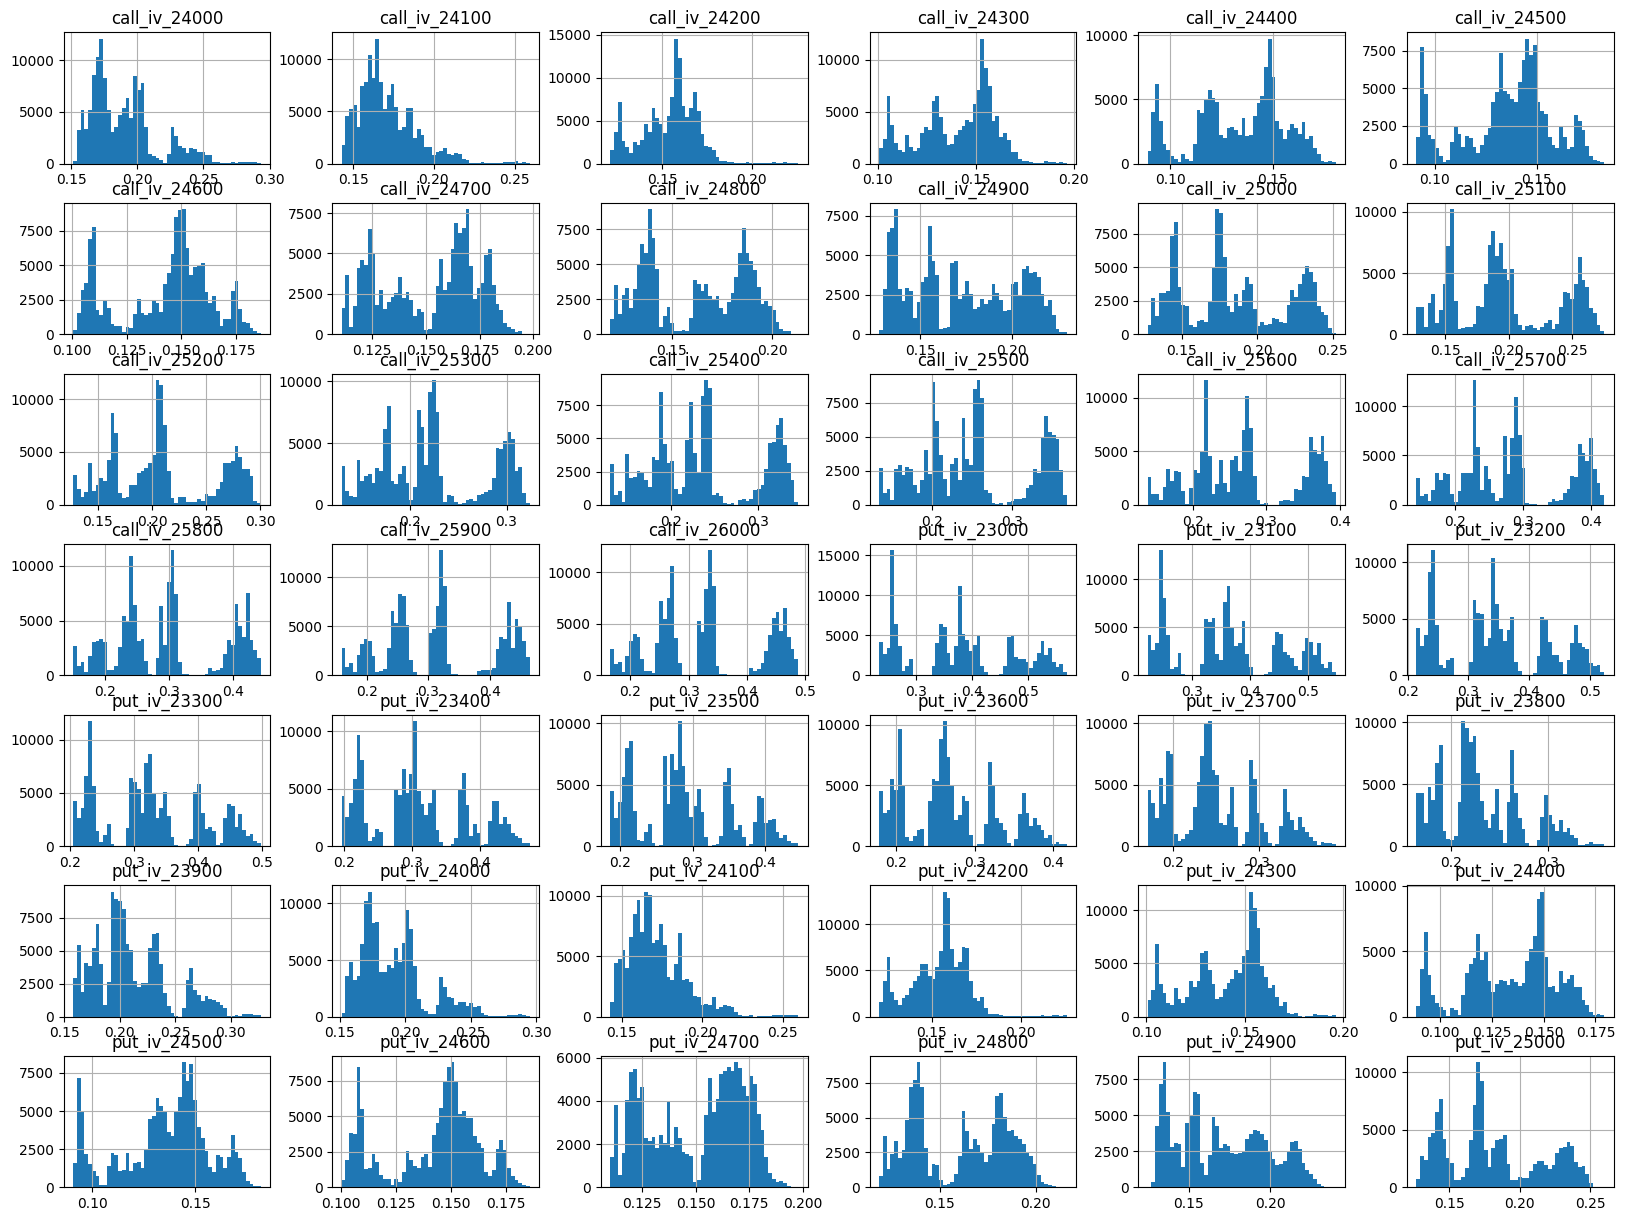

In [21]:
df_filtered[iv_cols].hist(bins=50, figsize=(20,15))
plt.show()

In [22]:
scaler = StandardScaler()

In [23]:
def preprocess(ds_frame):
  drop_worthy=['timestamp']
  filtered_df=ds_frame.drop(drop_worthy,axis=1)
  cols_to_scale = [col for col in filtered_df.columns if '_iv_' not in col]

# Apply StandardScaler to the identified columns
  filtered_df[cols_to_scale] = scaler.fit_transform(filtered_df[cols_to_scale])
  return filtered_df

In [24]:
df_ready=preprocess(df_filtered)
df_ready.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
19959,0.039065,0.168219,0.161882,0.156577,0.151857,0.148369,0.146395,0.145035,0.145138,0.146708,...,2.336909,0.624647,-0.221743,-0.748793,-2.789494,-0.249494,-0.151016,-0.160894,-0.225749,0.000307
19960,-0.003225,0.168580,0.161722,0.157152,0.152069,0.148666,0.146671,0.145355,0.145601,0.147036,...,-2.473049,0.645178,-1.406230,0.335245,-3.051003,0.623521,0.319457,0.160132,-2.719889,0.000307
19961,-0.003225,0.168531,0.162125,0.156902,0.151961,0.148529,0.146593,0.145155,0.145305,0.146820,...,-1.390307,-1.003913,1.514416,-0.379085,-2.244940,1.244083,-0.059793,0.334370,5.652808,0.000307
19962,-0.056607,0.168518,0.161966,0.156790,0.151924,0.148469,0.146579,0.145131,0.145360,0.146854,...,-1.060078,0.161439,2.390959,-2.132473,0.344595,-0.413319,-0.052737,8.335803,3.408793,0.000307
19963,-0.055914,0.168478,0.161900,0.156876,0.152012,0.148632,0.146707,0.145335,0.145408,0.146804,...,0.420108,-0.398663,2.216827,-1.924067,0.492794,-0.331203,0.533007,3.221962,1.933347,0.000307


In [25]:
df_fire=preprocess(test_df)
df_fire.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,NaN,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,NaN,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,NaN,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,NaN,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [27]:
lr=LinearRegression()

In [28]:
df_fire[test_spec_cols]

,call_iv_26100,call_iv_26200,call_iv_26300,call_iv_26400,call_iv_26500,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,NaN,0.416480,0.437552,NaN,0.482652,NaN,0.250422,NaN,NaN,0.282229
1,NaN,NaN,NaN,0.440725,NaN,0.249402,NaN,NaN,NaN,NaN
2,NaN,0.290094,NaN,NaN,0.336695,NaN,0.190750,NaN,NaN,NaN
3,0.279118,0.293905,NaN,NaN,0.342153,0.172032,NaN,NaN,NaN,0.206107
4,0.233272,0.244520,NaN,NaN,0.282333,0.176000,NaN,NaN,0.182314,NaN
...,...,...,...,...,...,...,...,...,...,...
12060,NaN,0.227919,0.238638,NaN,0.263555,NaN,0.176356,0.177716,NaN,NaN
12061,0.214229,0.222383,NaN,NaN,NaN,0.177923,NaN,0.180254,NaN,NaN
12062,0.274980,NaN,0.304301,0.320435,NaN,NaN,NaN,NaN,0.201360,0.209940
12063,NaN,NaN,0.228607,NaN,NaN,NaN,NaN,0.178806,NaN,NaN


In [29]:
from sklearn.impute import SimpleImputer,KNNImputer
simp_imp=SimpleImputer(missing_values=np.nan, strategy='mean')
knn_imputer=KNNImputer(n_neighbors=5)

In [30]:
df_fire_copy=df_fire.copy()
df_fire_copy.drop('underlying',axis=1,inplace=True)
from sklearn.impute import KNNImputer
import pandas as pd



# Transpose to treat rows as features (so KNN will work across columns)
df_fire_copy_T = df_fire_copy.T

# KNN Imputer (now imputes across original columns)
knn_imputer = KNNImputer(n_neighbors=3)
df_fire_copy_imputed_T = pd.DataFrame(
    knn_imputer.fit_transform(df_fire_copy_T),
    index=df_fire_copy_T.index,
    columns=df_fire_copy_T.columns
)
# Transpose back to original shape — this was the bug
df_fire_copy = df_fire_copy_imputed_T.T

# Add back 'underlying' column (assumed to be untouched)
df_fire_copy = pd.concat([df_fire['underlying'], df_fire_copy], axis=1)

# Fallback mean imputation for any remaining NaNs
simp_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_fire_imputed_copy = simp_imp.fit_transform(df_fire_copy)

# Convert back to DataFrame
df_fire_imputed_copy = pd.DataFrame(df_fire_imputed_copy, columns=df_fire_copy.columns)

# Preview
df_fire_imputed_copy.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,0.269181,0.269181,0.235641,0.242149,0.235641,0.232439,0.229257,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,0.272643,0.258893,0.245772,0.245772,0.235544,0.233548,0.230558,0.230558,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,0.258637,0.251731,0.238958,0.223727,0.214869,0.204580,0.194604,0.192423,0.183355,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,0.224375,0.220505,0.209947,0.198602,0.186190,0.171382,0.171382,0.166662,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,0.227342,0.222983,0.214126,0.202071,0.202071,0.192603,0.182174,0.182226,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [31]:
df_test_spec_imputed_cols=df_fire_imputed_copy[test_spec_cols]
df_test_spec_imputed_cols.head()

,call_iv_26100,call_iv_26200,call_iv_26300,call_iv_26400,call_iv_26500,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0.378324,0.416480,0.437552,0.445561,0.482652,0.243298,0.250422,0.249978,0.273631,0.282229
1,0.361269,0.390666,0.390666,0.440725,0.430729,0.249402,0.245713,0.263759,0.263759,0.263759
2,0.269023,0.290094,0.323440,0.323440,0.336695,0.185742,0.190750,0.191004,0.191004,0.191004
3,0.279118,0.293905,0.305059,0.320196,0.342153,0.172032,0.173285,0.186523,0.199288,0.206107
4,0.233272,0.244520,0.253375,0.274200,0.282333,0.176000,0.176664,0.179676,0.182314,0.184601


In [32]:
df_attack=df_fire.drop(test_spec_cols,axis=1)
df_attack.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,NaN,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,NaN,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,NaN,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,NaN,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [33]:
df_fire_imputed_copy_trainer=df_fire_imputed_copy.drop(test_spec_cols,axis=1)
df_fire_imputed_copy_trainer.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,0.269181,0.269181,0.235641,0.242149,0.235641,0.232439,0.229257,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,0.272643,0.258893,0.245772,0.245772,0.235544,0.233548,0.230558,0.230558,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,0.258637,0.251731,0.238958,0.223727,0.214869,0.204580,0.194604,0.192423,0.183355,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,0.224375,0.220505,0.209947,0.198602,0.186190,0.171382,0.171382,0.166662,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,0.227342,0.222983,0.214126,0.202071,0.202071,0.192603,0.182174,0.182226,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


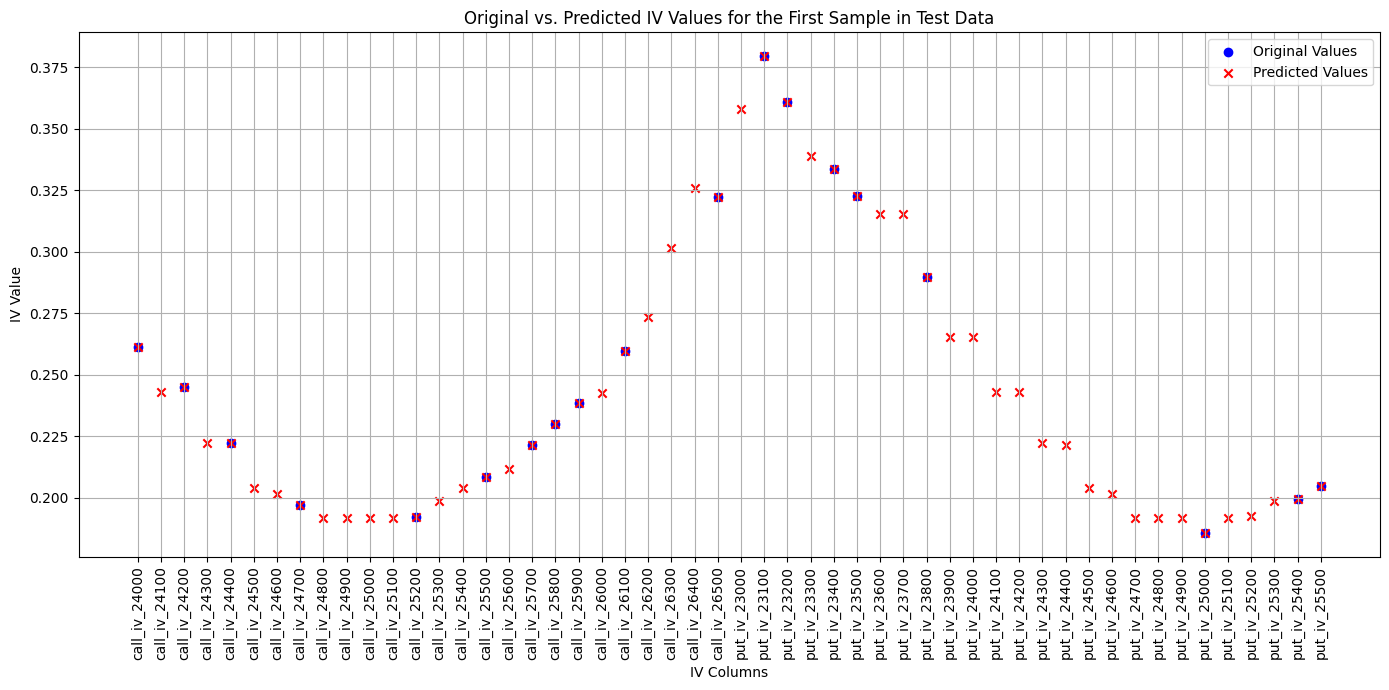

In [34]:
# prompt: plot of first row  test_iv_cols in df fire, colour predicted values in differnt colour

import matplotlib.pyplot as plt
# Assuming df_fire and submission_2_3 are already defined and contain the necessary data
# Get the first row of df_fire for original values
original_first_row = df_fire.iloc[754]

# Get the first row of submission_2_3 for predicted values
predicted_first_row = df_fire_imputed_copy.iloc[754]

# Identify the _iv_ columns from the original dataframe (or test_iv_cols list)
iv_cols_to_plot = test_iv_cols # Using the existing list from the preceding code

# Extract original and predicted IV values for the first row
original_iv_values = original_first_row[iv_cols_to_plot]
predicted_iv_values = predicted_first_row[iv_cols_to_plot]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot original values
plt.scatter(iv_cols_to_plot, original_iv_values, color='blue', label='Original Values', marker='o')

# Plot predicted values in a different color
plt.scatter(iv_cols_to_plot, predicted_iv_values, color='red', label='Predicted Values', marker='x')

# Add labels and title
plt.xlabel('IV Columns')
plt.ylabel('IV Value')
plt.title('Original vs. Predicted IV Values for the First Sample in Test Data')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
df_trial=df_attack.copy()

In [36]:
iv_cols

['call_iv_24000',
 'call_iv_24100',
 'call_iv_24200',
 'call_iv_24300',
 'call_iv_24400',
 'call_iv_24500',
 'call_iv_24600',
 'call_iv_24700',
 'call_iv_24800',
 'call_iv_24900',
 'call_iv_25000',
 'call_iv_25100',
 'call_iv_25200',
 'call_iv_25300',
 'call_iv_25400',
 'call_iv_25500',
 'call_iv_25600',
 'call_iv_25700',
 'call_iv_25800',
 'call_iv_25900',
 'call_iv_26000',
 'put_iv_23000',
 'put_iv_23100',
 'put_iv_23200',
 'put_iv_23300',
 'put_iv_23400',
 'put_iv_23500',
 'put_iv_23600',
 'put_iv_23700',
 'put_iv_23800',
 'put_iv_23900',
 'put_iv_24000',
 'put_iv_24100',
 'put_iv_24200',
 'put_iv_24300',
 'put_iv_24400',
 'put_iv_24500',
 'put_iv_24600',
 'put_iv_24700',
 'put_iv_24800',
 'put_iv_24900',
 'put_iv_25000']

In [37]:
df_fire_3=df_fire.copy()
df_fire_3.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,NaN,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,NaN,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,NaN,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,NaN,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


knn_reg = KNeighborsRegressor(n_neighbors=5)



In [ ]:
for iv in common_call_iv_cols:
  X=df_ready.drop([iv] + common_put_iv_cols, axis=1)
  y=df_ready[iv]
  knn_reg.fit(X, y)
  df_fire_imputed_copy_trainer_predictor=df_fire_imputed_copy_trainer.drop([iv] + common_put_iv_cols,axis=1)
  for i in range(len(df_attack)):
    if np.isnan(df_fire.loc[i, iv]):
      df_fire_3.loc[i, iv] = knn_reg.predict(df_fire_imputed_copy_trainer_predictor.loc[i].values.reshape(1, -1))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featu

In [ ]:
for iv in common_put_iv_cols:
  X=df_ready.drop([iv] + common_call_iv_cols, axis=1)
  y=df_ready[iv]
  knn_reg.fit(X, y)
  df_fire_imputed_copy_trainer_predictor=df_fire_imputed_copy_trainer.drop([iv] + common_call_iv_cols,axis=1)
  for i in range(len(df_attack)):
    if np.isnan(df_fire.loc[i, iv]):
      df_fire_3.loc[i, iv] = knn_reg.predict(df_fire_imputed_copy_trainer_predictor.loc[i].values.reshape(1, -1))


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featu

In [ ]:

df_fire_3.to_csv('trial.csv',index=False)

In [ ]:
df_fire_3[test_spec_cols]

,call_iv_26100,call_iv_26200,call_iv_26300,call_iv_26400,call_iv_26500,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,NaN,0.416480,0.437552,NaN,0.482652,NaN,0.250422,NaN,NaN,0.282229
1,NaN,NaN,NaN,0.440725,NaN,0.249402,NaN,NaN,NaN,NaN
2,NaN,0.290094,NaN,NaN,0.336695,NaN,0.190750,NaN,NaN,NaN
3,0.279118,0.293905,NaN,NaN,0.342153,0.172032,NaN,NaN,NaN,0.206107
4,0.233272,0.244520,NaN,NaN,0.282333,0.176000,NaN,NaN,0.182314,NaN
...,...,...,...,...,...,...,...,...,...,...
12060,NaN,0.227919,0.238638,NaN,0.263555,NaN,0.176356,0.177716,NaN,NaN
12061,0.214229,0.222383,NaN,NaN,NaN,0.177923,NaN,0.180254,NaN,NaN
12062,0.274980,NaN,0.304301,0.320435,NaN,NaN,NaN,NaN,0.201360,0.209940
12063,NaN,NaN,0.228607,NaN,NaN,NaN,NaN,0.178806,NaN,NaN


In [ ]:
df_fire_3[common_cols].describe().loc['max']

,max
call_iv_24000,0.329322
call_iv_24100,0.325091
call_iv_24200,0.294849
call_iv_24300,0.280493
call_iv_24400,0.267558
call_iv_24500,0.257639
call_iv_24600,0.250346
call_iv_24700,0.245681
call_iv_24800,0.241232
call_iv_24900,0.244315


In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd



# Transpose to treat rows as features (so KNN will work across columns)
df_trial_T = df_trial.T

# KNN Imputer (now imputes across original columns)
knn_imputer = KNNImputer(n_neighbors=3)
df_fire_copy_imputed_T = pd.DataFrame(
    knn_imputer.fit_transform(df_fire_copy_T),
    index=df_fire_copy_T.index,
    columns=df_fire_copy_T.columns
)
# Transpose back to original shape — this was the bug
df_fire_copy = df_fire_copy_imputed_T.T

# Add back 'underlying' column (assumed to be untouched)
df_fire_copy = pd.concat([df_fire['underlying'], df_fire_copy], axis=1)

# Fallback mean imputation for any remaining NaNs
simp_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_fire_imputed_copy = simp_imp.fit_transform(df_fire_copy)

# Convert back to DataFrame
df_fire_imputed_copy = pd.DataFrame(df_fire_imputed_copy, columns=df_fire_copy.columns)

# Preview
df_fire_imputed_copy.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,0.269181,0.269181,0.235641,0.242149,0.235641,0.232439,0.229257,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,0.272643,0.258893,0.245772,0.245772,0.235544,0.233548,0.230558,0.230558,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,0.258637,0.251731,0.238958,0.223727,0.214869,0.204580,0.194604,0.192423,0.183355,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,0.224375,0.220505,0.209947,0.198602,0.186190,0.171382,0.171382,0.166662,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,0.227342,0.222983,0.214126,0.202071,0.202071,0.192603,0.182174,0.182226,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [ ]:
jdf=pd.read_csv('trial.csv')
jdf.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,0.165701,0.147191,0.133648,0.242149,0.134822,0.232439,0.158050,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,0.168210,0.258893,0.133363,0.132299,0.142246,0.233548,0.171834,0.187410,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,0.198976,0.251731,0.156819,0.141270,0.214869,0.204580,0.194604,0.153198,0.163511,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,0.165077,0.220505,0.122010,0.198602,0.186190,0.117469,0.129299,0.143127,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,0.178318,0.222983,0.214126,0.125408,0.128086,0.192603,0.150425,0.162438,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [ ]:
# prompt: jdf cells with _iv_ columns should be below test_df[iv_cols].describe().loc['max'].max()

#jdf[iv_cols] = jdf[iv_cols].where( (jdf[iv_cols] < test_df[iv_cols].describe().loc['max'].max() ), np.nan)
#jdf[iv_cols] = jdf[iv_cols].fillna(method='ffill').fillna(method='bfill')

In [ ]:
jdf[iv_cols].describe().loc['max']

,max
call_iv_24000,0.329322
call_iv_24100,0.325091
call_iv_24200,0.294849
call_iv_24300,0.280493
call_iv_24400,0.267558
call_iv_24500,0.257639
call_iv_24600,0.250346
call_iv_24700,0.245681
call_iv_24800,0.241232
call_iv_24900,0.244315


In [ ]:
jdf.columns

Index(['underlying', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200',
       'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600',
       'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000',
       'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400',
       'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800',
       'call_iv_25900', 'call_iv_26000', 'call_iv_26100', 'call_iv_26200',
       'call_iv_26300', 'call_iv_26400', 'call_iv_26500', 'put_iv_23000',
       'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400',
       'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800',
       'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200',
       'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600',
       'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000',
       'put_iv_25100', 'put_iv_25200', 'put_iv_25300', 'put_iv_25400',
       'put_iv_25500', 'X0', 'X1', 'X2', 'X3', 'X4', 

In [ ]:
test_cols

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [ ]:
jdf_call_iv_cols=[col for col in jdf.columns if "call_iv_" in col]
jdf_call_iv_cols

['call_iv_24000',
 'call_iv_24100',
 'call_iv_24200',
 'call_iv_24300',
 'call_iv_24400',
 'call_iv_24500',
 'call_iv_24600',
 'call_iv_24700',
 'call_iv_24800',
 'call_iv_24900',
 'call_iv_25000',
 'call_iv_25100',
 'call_iv_25200',
 'call_iv_25300',
 'call_iv_25400',
 'call_iv_25500',
 'call_iv_25600',
 'call_iv_25700',
 'call_iv_25800',
 'call_iv_25900',
 'call_iv_26000',
 'call_iv_26100',
 'call_iv_26200',
 'call_iv_26300',
 'call_iv_26400',
 'call_iv_26500']

In [ ]:
jdf_put_iv_cols=[col for col in jdf.columns if "put_iv_" in col]
jdf_put_iv_cols

['put_iv_23000',
 'put_iv_23100',
 'put_iv_23200',
 'put_iv_23300',
 'put_iv_23400',
 'put_iv_23500',
 'put_iv_23600',
 'put_iv_23700',
 'put_iv_23800',
 'put_iv_23900',
 'put_iv_24000',
 'put_iv_24100',
 'put_iv_24200',
 'put_iv_24300',
 'put_iv_24400',
 'put_iv_24500',
 'put_iv_24600',
 'put_iv_24700',
 'put_iv_24800',
 'put_iv_24900',
 'put_iv_25000',
 'put_iv_25100',
 'put_iv_25200',
 'put_iv_25300',
 'put_iv_25400',
 'put_iv_25500']

In [ ]:
test_spec_call_iv_cols=[col for col in test_spec_cols if "call_iv_" in col]
test_spec_call_iv_cols

['call_iv_26100',
 'call_iv_26200',
 'call_iv_26300',
 'call_iv_26400',
 'call_iv_26500']

In [ ]:
test_spec_put_iv_cols=[col for col in test_spec_cols if "put_iv_" in col]
test_spec_put_iv_cols

['put_iv_25100',
 'put_iv_25200',
 'put_iv_25300',
 'put_iv_25400',
 'put_iv_25500']

In [ ]:
submission_2_1=pd.concat([test_df['timestamp'],jdf[jdf_call_iv_cols],df_test_spec_imputed_cols[test_spec_call_iv_cols],jdf[jdf_put_iv_cols],df_test_spec_imputed_cols[test_spec_put_iv_cols]],axis=1)
submission_2_1.head()

,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.165701,0.147191,0.133648,0.242149,0.134822,0.232439,0.158050,0.222997,...,NaN,0.250422,NaN,NaN,0.282229,0.243298,0.250422,0.249978,0.273631,0.282229
1,1,0.270276,0.168210,0.258893,0.133363,0.132299,0.142246,0.233548,0.171834,0.187410,...,0.249402,NaN,NaN,NaN,NaN,0.249402,0.245713,0.263759,0.263759,0.263759
2,2,0.198976,0.251731,0.156819,0.141270,0.214869,0.204580,0.194604,0.153198,0.163511,...,NaN,0.190750,NaN,NaN,NaN,0.185742,0.190750,0.191004,0.191004,0.191004
3,3,0.241888,0.165077,0.220505,0.122010,0.198602,0.186190,0.117469,0.129299,0.143127,...,0.172032,NaN,NaN,NaN,0.206107,0.172032,0.173285,0.186523,0.199288,0.206107
4,4,0.235328,0.178318,0.222983,0.214126,0.125408,0.128086,0.192603,0.150425,0.162438,...,0.176000,NaN,NaN,0.182314,NaN,0.176000,0.176664,0.179676,0.182314,0.184601


In [ ]:
df_fire_2=df_fire.copy()
df_fire_2[df_trial.columns]=df_trial[df_trial.columns]
df_fire_2.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,NaN,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,NaN,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,NaN,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,NaN,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [ ]:
submission_2_1.to_csv('submission_2_2.csv',index=False)

In [ ]:
submission_2_1.describe().loc['max']

,max
timestamp,12064.000000
call_iv_24000,0.329322
call_iv_24100,0.325091
call_iv_24200,0.294849
call_iv_24300,0.280493
...,...
put_iv_25100,0.263409
put_iv_25200,0.270239
put_iv_25300,0.286829
put_iv_25400,0.316621


In [ ]:
submission_2_1[iv_cols].describe().loc['max'].max()

0.552474

In [ ]:
test_df[iv_cols].describe().loc['max'].max()

0.536715

In [ ]:
for iv in test_spec_call_iv_cols:
  X=df_fire_imputed_copy.drop([iv]+test_put_iv_cols, axis=1)
  y=df_fire_imputed_copy[iv]
  knn_reg.fit(X, y)
  df_fire_imputed_copy_trainer_predictor_2=df_fire_imputed_copy.drop([iv]+test_put_iv_cols,axis=1)
  for i in range(len(df_attack)):
    if np.isnan(df_fire_2.loc[i, iv]):
      df_fire_3.loc[i, iv] = knn_reg.predict(df_fire_imputed_copy_trainer_predictor_2.loc[i].values.reshape(1, -1))


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featu

In [ ]:
for iv in test_spec_put_iv_cols:
  X=df_fire_imputed_copy.drop([iv]+test_call_iv_cols, axis=1)
  y=df_fire_imputed_copy[iv]
  knn_reg.fit(X, y)
  df_fire_imputed_copy_trainer_predictor_2=df_fire_imputed_copy.drop([iv]+test_call_iv_cols, axis=1)
  for i in range(len(df_attack)):
    if np.isnan(df_fire_2.loc[i, iv]):
      df_fire_3.loc[i, iv] = knn_reg.predict(df_fire_imputed_copy_trainer_predictor_2.loc[i].values.reshape(1, -1))

df_fire_3.to_csv('trial_2.csv',index=False)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featu

In [ ]:
df_fire_3.to_csv('trial_2.csv',index=False)

In [ ]:
df_fire_2.head()

,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,-1.661569,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,0.222997,...,0.663962,0.092911,-0.024374,-0.063603,-0.392946,0.046047,0.398702,-0.004258,0.006258,-0.559490
1,-1.332567,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,NaN,...,0.580920,0.161123,-0.041717,-0.235256,-0.066972,-0.053319,-0.755161,-0.370345,-0.672751,0.492133
2,0.058213,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,NaN,...,0.073646,-1.369281,0.118565,0.381197,0.849529,1.793902,0.509732,-0.004258,-0.023866,-0.275940
3,0.071031,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,NaN,...,-0.967149,-0.905692,-0.565335,0.031009,0.265579,-0.064622,-1.308013,-0.434649,-1.670228,-1.951433
4,0.160759,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,NaN,...,-1.925825,-0.310247,-0.051909,-1.557104,0.109752,-0.534139,0.275949,0.053375,1.608930,0.323592


In [ ]:
submission_2_3=pd.concat([test_df['timestamp'],df_fire_3[test_iv_cols]],axis=1)
submission_2_3.head()

,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.165701,0.147191,0.133648,0.242149,0.134822,0.232439,0.158050,0.222997,...,0.232334,0.166761,0.179281,0.227301,0.234169,0.230839,0.250422,0.242412,0.251053,0.282229
1,1,0.270276,0.168210,0.258893,0.133363,0.132299,0.142246,0.233548,0.171834,0.187410,...,0.156691,0.228209,0.186937,0.206554,0.220918,0.249402,0.247612,0.256291,0.257557,0.263257
2,2,0.198976,0.251731,0.156819,0.141270,0.214869,0.204580,0.194604,0.153198,0.163511,...,0.194612,0.188052,0.163410,0.172285,0.181346,0.178251,0.190750,0.185351,0.190424,0.194477
3,3,0.241888,0.165077,0.220505,0.122010,0.198602,0.186190,0.117469,0.129299,0.143127,...,0.123304,0.166394,0.161561,0.168967,0.187433,0.172032,0.214327,0.222970,0.228409,0.206107
4,4,0.235328,0.178318,0.222983,0.214126,0.125408,0.128086,0.192603,0.150425,0.162438,...,0.144055,0.159798,0.174359,0.177920,0.207597,0.176000,0.194335,0.200187,0.182314,0.210902


In [ ]:
#submission_2_3[test_iv_cols] = submission_2_3[test_iv_cols].where( (submission_2_3[test_iv_cols] < test_df[test_iv_cols].describe().loc['max'].max() ), np.nan)
#submission_2_3[test_iv_cols] = submission_2_3[test_iv_cols].fillna(method='ffill').fillna(method='bfill')

In [ ]:
submission_2_3[test_iv_cols].describe().loc['max'].max()

0.552474

In [ ]:
submission_2_3.shape

(12065, 53)

In [ ]:
submission_2_3.to_csv('submission_2_6.csv',index=False)

In [ ]:
submission_2_3.head()

,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.165701,0.147191,0.133648,0.242149,0.134822,0.232439,0.158050,0.222997,...,0.232334,0.166761,0.179281,0.227301,0.234169,0.230839,0.250422,0.242412,0.251053,0.282229
1,1,0.270276,0.168210,0.258893,0.133363,0.132299,0.142246,0.233548,0.171834,0.187410,...,0.156691,0.228209,0.186937,0.206554,0.220918,0.249402,0.247612,0.256291,0.257557,0.263257
2,2,0.198976,0.251731,0.156819,0.141270,0.214869,0.204580,0.194604,0.153198,0.163511,...,0.194612,0.188052,0.163410,0.172285,0.181346,0.178251,0.190750,0.185351,0.190424,0.194477
3,3,0.241888,0.165077,0.220505,0.122010,0.198602,0.186190,0.117469,0.129299,0.143127,...,0.123304,0.166394,0.161561,0.168967,0.187433,0.172032,0.214327,0.222970,0.228409,0.206107
4,4,0.235328,0.178318,0.222983,0.214126,0.125408,0.128086,0.192603,0.150425,0.162438,...,0.144055,0.159798,0.174359,0.177920,0.207597,0.176000,0.194335,0.200187,0.182314,0.210902


In [ ]:
submission_2_3.isna().sum().sort_values(ascending=False)

,0
timestamp,0
call_iv_24000,0
call_iv_24100,0
call_iv_24200,0
call_iv_24300,0
call_iv_24400,0
call_iv_24500,0
call_iv_24600,0
call_iv_24700,0
call_iv_24800,0


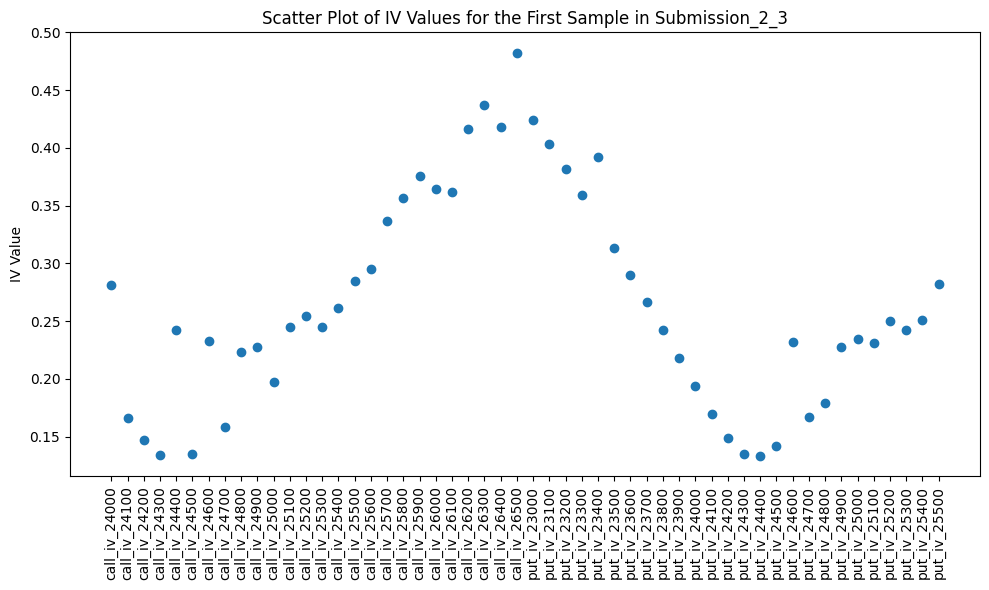

In [ ]:
# prompt: #scatter PLOT first sample of OF SUBMISSION 2_3,for the columns having_iv on their name

import matplotlib.pyplot as plt
# Get the first sample (row) of submission_2_3
first_sample = submission_2_3.iloc[0]

# Identify columns in the first sample that have "_iv_" in their name
iv_cols_sample = [col for col in first_sample.index if "_iv_" in col]

# Extract the values for the identified columns
iv_values_sample = first_sample[iv_cols_sample]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(iv_cols_sample, iv_values_sample, marker='o')
plt.xticks(rotation=90)
plt.ylabel('IV Value')
plt.title('Scatter Plot of IV Values for the First Sample in Submission_2_3')
plt.tight_layout()
plt.show()

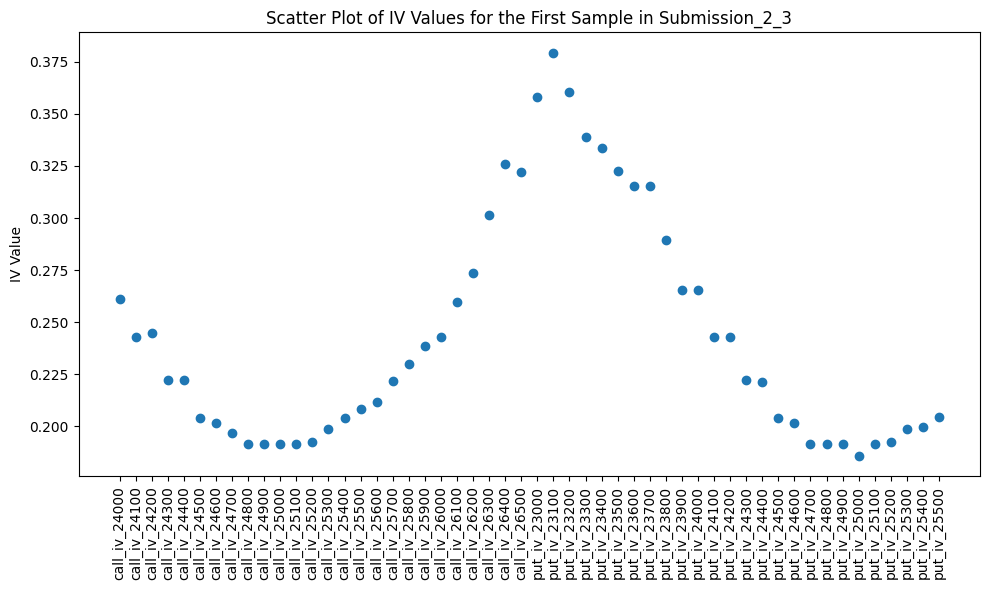

In [ ]:
# prompt: #scatter PLOT first sample of OF SUBMISSION 2_3,for the columns having_iv on their name

import matplotlib.pyplot as plt
# Get the first sample (row) of submission_2_3
first_sample = df_fire_imputed_copy.iloc[754]

# Identify columns in the first sample that have "_iv_" in their name
iv_cols_sample = [col for col in first_sample.index if "_iv_" in col]

# Extract the values for the identified columns
iv_values_sample = first_sample[iv_cols_sample]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(iv_cols_sample, iv_values_sample, marker='o')
plt.xticks(rotation=90)
plt.ylabel('IV Value')
plt.title('Scatter Plot of IV Values for the First Sample in Submission_2_3')
plt.tight_layout()
plt.show()

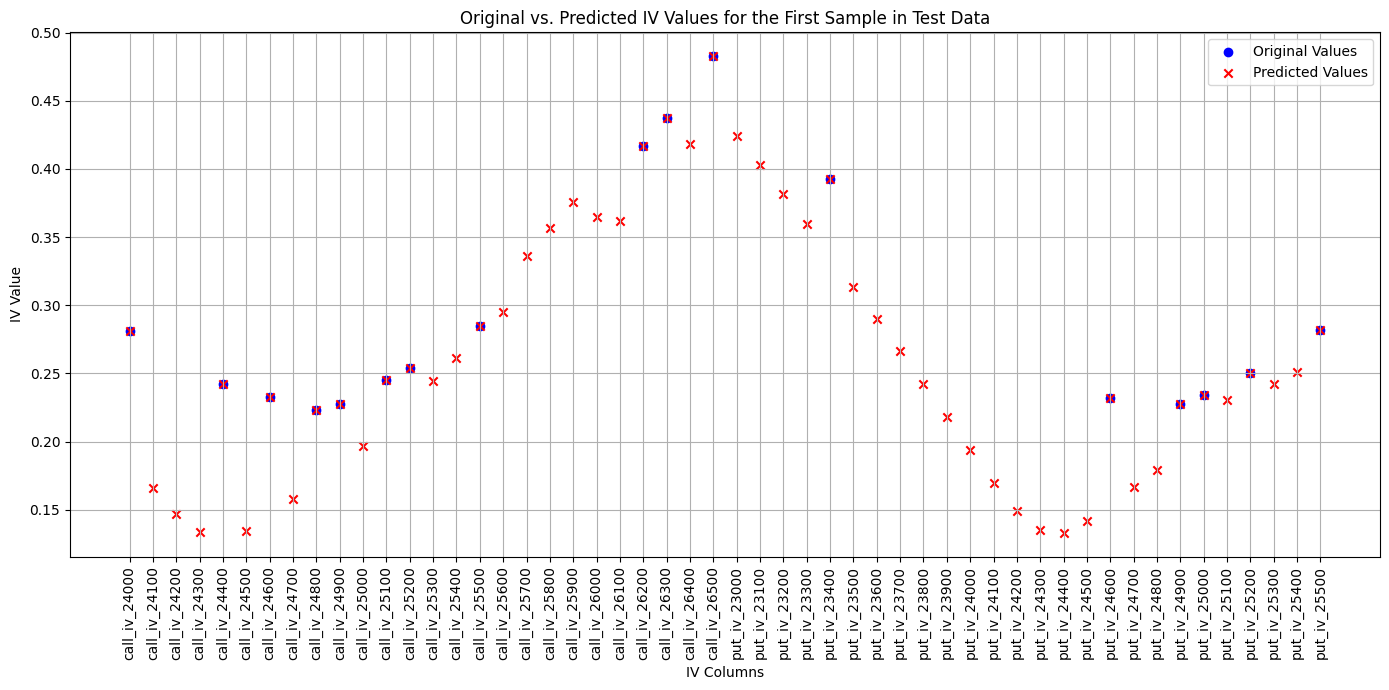

In [ ]:
# prompt: plot of first row  test_iv_cols in df fire, colour predicted values in differnt colour

import matplotlib.pyplot as plt
# Assuming df_fire and submission_2_3 are already defined and contain the necessary data
# Get the first row of df_fire for original values
original_first_row = df_fire.iloc[0]

# Get the first row of submission_2_3 for predicted values
predicted_first_row = submission_2_3.iloc[0]

# Identify the _iv_ columns from the original dataframe (or test_iv_cols list)
iv_cols_to_plot = test_iv_cols # Using the existing list from the preceding code

# Extract original and predicted IV values for the first row
original_iv_values = original_first_row[iv_cols_to_plot]
predicted_iv_values = predicted_first_row[iv_cols_to_plot]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot original values
plt.scatter(iv_cols_to_plot, original_iv_values, color='blue', label='Original Values', marker='o')

# Plot predicted values in a different color
plt.scatter(iv_cols_to_plot, predicted_iv_values, color='red', label='Predicted Values', marker='x')

# Add labels and title
plt.xlabel('IV Columns')
plt.ylabel('IV Value')
plt.title('Original vs. Predicted IV Values for the First Sample in Test Data')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
itftj

NameError: name 'itftj' is not defined

In [ ]:
mean_absolute_error_test=[]
mean_absolute_error_train=[]
y_pred_test_list=[]
y_pred_train_list=[]
Y_test_list=[]
Y_train_list=[]

In [ ]:
for iv in iv_cols:
  X=filtered_df.drop(iv, axis=1)
  y=filtered_df[iv]
  X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_train)
  mean_absolute_error_train.append(mean_absolute_error(y_train, y_pred))
  y_pred_test = lr.predict(X_validate)
  mean_absolute_error_test.append(mean_absolute_error(y_validate, y_pred_test))
  y_pred_test_list.append(y_pred_test)
  y_pred_train_list.append(y_pred)
  Y_test_list.append(y_validate)
  Y_train_list.append(y_train)

In [ ]:
#plot
plt.figure(figsize=(10, 6))
plt.plot(iv_cols[6:], mean_absolute_error_train[6:], marker='o', label='Train')
plt.plot(iv_cols[6:], mean_absolute_error_test[6:], marker='o', label='Test')

In [ ]:
y_test_df=pd.DataFrame(Y_test_list)
y_train_df=pd.DataFrame(Y_train_list)
y_pred_test_df=pd.DataFrame(y_pred_test_list)
y_pred_train_df=pd.DataFrame(y_pred_train_list)

In [ ]:
y_test_df.head()

In [ ]:
#plot y_pred_test vs y_test
plt.figure(figsize=(10, 6))
plt.scatter(y_validate, y_pred_test, label='Test Data')

In [ ]:
y_pred

In [ ]:
df_test_para=pd.read_parquet('test_data.parquet',engine='auto')

In [ ]:
timestamp_series=df_test_para['timestamp']

In [ ]:
df_test_para.drop("timestamp",axis=1,inplace=True)

In [ ]:
iv_cols_test=[col_test for col_test in df_test_para.columns if "_iv_" in col_test]
iv_cols_test

In [ ]:
# prompt: show the column names same in test_para and filtered_df

test_para_set = df_test_para.columns
filtered_df_cols = filtered_df.columns
print("Columns present in both dataframes:")
common_col_list=[]
for common_col in test_para_set.intersection(filtered_df_cols):
  common_col_list.append(common_col)

In [ ]:
df_test_p1=df_test_para[common_col_list]
df_test_p1.shape

In [ ]:
df_test_p1

In [ ]:
df_test_para_copy=df_test_para.copy()

In [ ]:
from sklearn.impute import SimpleImputer
simp_imp=SimpleImputer(missing_values=np.nan, strategy='median')
#use imputer
imputed_df_test_para_copy=simp_imp.fit_transform(df_test_para_copy)
imputed_df_test_para_copy=pd.DataFrame(imputed_df_test_para_copy,columns=df_test_para_copy.columns)
imputed_df_test_para_copy.head()

In [ ]:
df_target=imputed_df_test_para_copy[iv_cols_test]
df_target.head()

In [ ]:
#concatenate series_timestamp and  df_target
df_target=pd.concat([timestamp_series,df_target],axis=1)
df_target.head()

In [ ]:
df_target.to_csv('submission_1_1.csv',index=False)